In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
#Use test datsets to test methods#
#Bring in forest fires#
#Transform Burned area to ln(area+1)#

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [4]:
#Editable Variables
#list of test filters
zerosperrow = [0.9,0.6,0.3]
for z in zerosperrow:
    multi_files = True  #set to false if you just want to set one  prot_abund_file
    in_dir = "Input_data/Proteomic data/Abundance2/"
    prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
    NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
    controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
    uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
    NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
    id = 'all_NoCon_RFE40_droprows' + str(z) + 'zeros'
    RFE_Feats = 40
    model = RandomForestRegressor(n_estimators=150)
    # take files in_dir and combine then into one pandas df (raw_MS_data) ###USE when combining multiple datasets####
    # melt the df to make it an accession number, NPUNID, Abundance dataset before combining
    files = os.listdir(in_dir)
    if multi_files == True:
        for i, f in enumerate(files):
            if i == 0:
                raw_MS_data = pd.read_excel(in_dir + f, header=0)
                cols = raw_MS_data.shape[1]
                cutoff = int(z * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                # print(raw_MS_data)
                raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

            else:

                temp = pd.read_excel(in_dir + f, header=0)
                cols = temp.shape[1]
                cutoff = int(z * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

                raw_MS_data = pd.concat([raw_MS_data, temp])
                print('final shape after melt', raw_MS_data.shape)
                print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())

    else:
        raw_MS_data = pd.read_excel(prot_abund_file, header=0)
        cols = raw_MS_data.shape[1]
        cutoff = int(z * cols)
        print('shape beofre dropping rows', raw_MS_data.shape)
        raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
        print('shape after dropping rows', raw_MS_data.shape)
        raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
    #remove prots that were added due to merge
    raw_MS_data = raw_MS_data.dropna()
    ###Bring in controls (MS data for serums)##
    controls = pd.read_excel(controls_file, header=0)
    MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
    ###Bring in Uniprot_data,NSPdata and NP data##
    uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
    NSP_data = pd.read_excel(NSPfilePath)
    ###Bring in NP data and merge to get complete NP dataset###
    NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
    NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
    NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
    NPdata.dropna(inplace=True)
    #calculate Enrichment
    #####MAYBE add binning here to keep negative results and improve capapbilities######
    # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
    # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
    #keep abundance Controls
    # MS_data=MS_data_controls.drop(columns=['Abundance'])
    raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
    Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
                                     on='Entry')  #merges netsurfp features and biopython features
    Protein_data_complete.fillna(0, inplace=True)
    #creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
    for df in [Protein_data_complete]:
        for col in ['asa_sum']:
            df[col + '_normalized'] = df[col] / df['Mass']

    data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
    data_complete.drop(columns=['notes', 'Notes', 'NPUNID'], inplace=True)
    data_complete.fillna(0, inplace=True)
    data_complete = data_complete.replace([-np.inf], '-12')
    data_complete = data_complete.replace([np.inf], '12')
    #create ordinal variables
    # data_complete2=pd.get_dummies(data_complete, columns=['Core Material','Surface_Ligand'])
    le = LabelEncoder()
    data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
    data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])

    #set labels (what we are trying to predict) as Enrichment column
    # labels=data_complete['Enrichment'].copy()
    label_abund = np.ravel(data_complete['Abundance'].copy())
    label_abund_df = pd.DataFrame(label_abund)
    # label_enrich=np.ravel(data_complete['Enrichment'].copy())
    #make it one dimenisional
    #drop qualitative, not neccessary, and label columns
    #create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
    to_drop = data_complete.filter(like='total_exposed_')
    data_complete.drop(columns=to_drop, inplace=True)
    df = data_complete.drop(
        ['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5',
         'Raw_FileID'], axis=1)
    df.drop(columns=['Abundance_Controls'], inplace=True)

    # df.to_excel("Input_data/Save_files/df_"+id+".xlsx")
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)

    #Run PCA to seee how data differentiates#
    scaler = StandardScaler()
    X_std = scaler.fit_transform(df)
    pca = PCA(n_components=5)
    x_pca = pca.fit_transform(X_std)
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label_abund, cmap='viridis')
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig('Output_data/PCA' + id + '.png')
    plt.close('all')
    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    step = 2
    estimator = RandomForestRegressor(n_estimators=100)
    selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df, label_abund)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df = df[feat_list]

    #run Recursive feature elimination with cross validation
    step = 2
    min_feats = 6
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    estimator = RandomForestRegressor(n_estimators=100)
    selector = RFECV(estimator=estimator, cv=cv, scoring='neg_mean_squared_error', min_features_to_select=min_feats, step=step)
    selector = selector.fit(df, label_abund)
    selector.support_
    feat_list2 = selector.get_feature_names_out()
    selected_features = df.columns[selector.support_]
    df = df[feat_list2]
    # df.to_excel("Input_data/Save_files/df_RFECV"+id+id2+".xlsx")
    # rfecv_df=pd.DataFrame(selector.cv_results_)
    # rfecv_df.to_excel("Output_data/RFECV_results"+id+id2+".xlsx")
    # label_abund_df.to_excel("Input_data/Save_files/label_abund_all.xlsx")
    n_scores = len(selector.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    x = range(1, n_scores + 1)
    y = selector.cv_results_["mean_test_score"]
    err = selector.cv_results_["std_test_score"]
    plt.plot(x, y, 'k-')
    plt.fill_between(x, y - err, y + err)
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.savefig('Output_data/RFECV' + id + '.png')
    plt.close('all')

    #Quality control
    scram_score(df, label_abund, model, id, 0.2)
    feat_drop(df, label_abund, model, id, 0.2)
    scorer(df, label_abund, model, id, 10)

print('done')


shape before dropping rows (474, 14)
shape after dropping rows (220, 14)
shape before dropping rows (2860, 3)
shape after dropping rows (2860, 3)
final shape after melt (21945, 3)
number of zeros in the dataset: 11050


C:\Users\pouls\AppData\Local\Temp\ipykernel_12920\3186484504.py:115: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Scramble Scoring ran successfully
feat drop ran successfully
Scorer ran successfully
shape before dropping rows (474, 14)
shape after dropping rows (64, 14)
shape before dropping rows (832, 3)
shape after dropping rows (832, 3)
final shape after melt (11447, 3)
number of zeros in the dataset: 2758


C:\Users\pouls\AppData\Local\Temp\ipykernel_12920\3186484504.py:115: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Scramble Scoring ran successfully
feat drop ran successfully
Scorer ran successfully
shape before dropping rows (474, 14)
shape after dropping rows (27, 14)
shape before dropping rows (351, 3)
shape after dropping rows (351, 3)
final shape after melt (6841, 3)
number of zeros in the dataset: 752


C:\Users\pouls\AppData\Local\Temp\ipykernel_12920\3186484504.py:115: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Scramble Scoring ran successfully
feat drop ran successfully
Scorer ran successfully
done


In [6]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold_idx, (train_index, test_index) in enumerate(kfold.split(df, label_abund)):
    print(fold_idx)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [9]:
feat_drop(df, label_abund, model, id, 0.2)

feat drop ran successfully


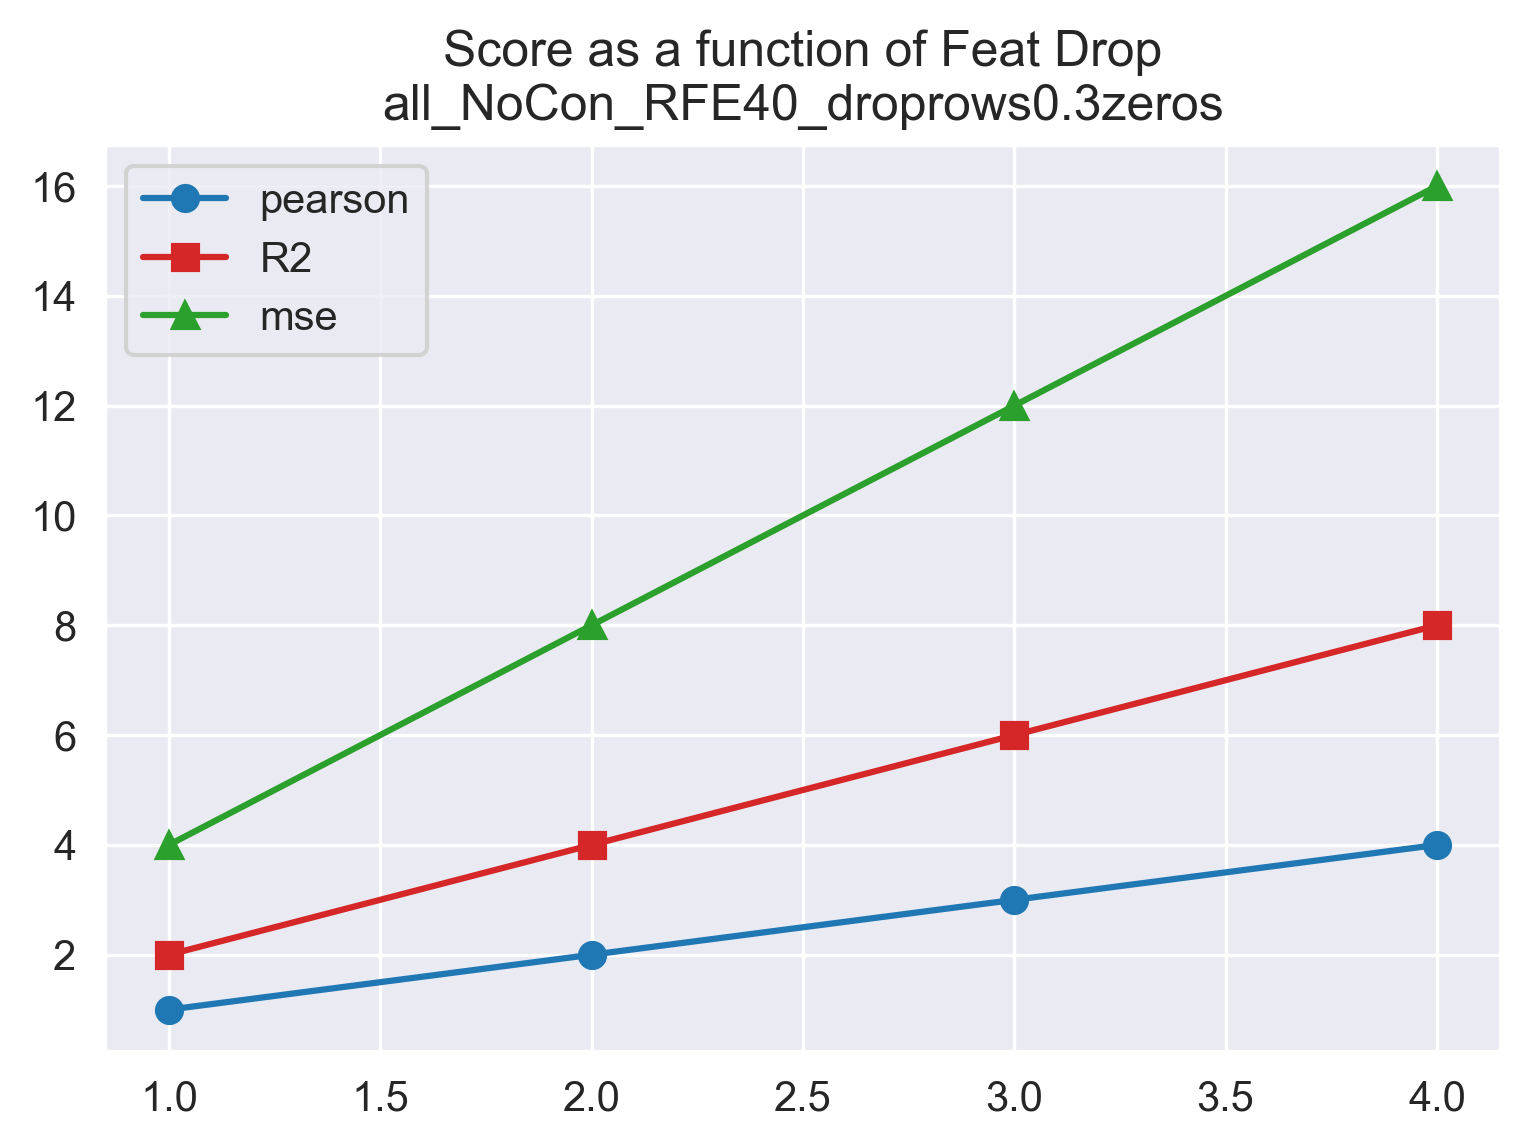

In [7]:
x=[1,2,3,4]
y=[1,2,3,4]
y2=[2,4,6,8]
y3=[4,8,12,16]

plt.plot(x, y, color='tab:blue', marker='o',label='pearson')
plt.plot(x, y2, color='tab:red', marker='s',label='R2')
plt.plot(x, y3, color='tab:green', marker='^',label='mse')
plt.legend()

plt.title('Score as a function of Feat Drop\n'+id)
plt.savefig('Output_data/feat_drop_cumulative' + id + '.png', bbox_inches='tight')

In [6]:
print(y2)

[1, 2, 3, 4, 1, 2, 3, 4]


In [4]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [7]:
scorer(df, label_abund, model, id, 10)

Scorer ran successfully
